# KANG Jiale

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

5


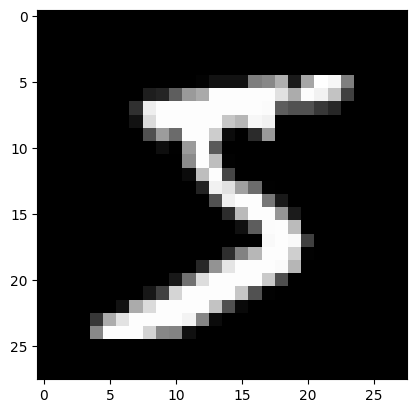

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [3]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()


Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100]

array([0, 5, 5, 0, 5, 5, 0, 5, 0, 0, 5, 0, 0, 5, 0, 5, 5, 5, 3, 3, 4, 5,
       3, 0, 4, 0, 0, 0, 0, 0, 0, 5, 5, 3, 0, 0, 0, 0, 5, 5, 0, 5, 5, 5,
       0, 5, 5, 0, 5, 0, 3, 8, 0, 0, 0, 0, 5, 5, 5, 0, 4, 0, 0, 5, 5, 0,
       0, 0, 5, 5, 0, 0, 0, 0, 0, 5, 3, 0, 3, 0, 0, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 4, 5, 0, 5, 5, 5, 5, 0, 0], dtype=int64)

In [5]:
# what we would like to get
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

In [6]:
## Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        logits = model(x_train_batch)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

## Updating weights

def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)


## Evaluate model
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()
    

2.319369

## Question 4.1

How many optimization variables are we going to train using this model?

For the first dense layer (dense_1), there are 784 input features and 32 neurons. Therefore, it has $784\times 32$ weights plus 32 biases. For the second dense layer (dense_2), it is fully connected to the first dense layer which has 32 neurons. Thus, it has $32 \times 32$ weights plus 32 biases. Finally, the output layer (predictions) has 32 inputs from the second dense layer and 10 output neurons (since there are 10 classes for digits 0 through 9). Therefore, it has $32 \times 10$ weights plus 10 biases.

The total number of optimization variables is the sum of all weights and biases across all layers:$(784\times 32+784) + (32\times 32 + 32) + (32 \times 10 + 10) =26506$

## Question 5.1

Reusing the code provided in the basic functions file, implement stochastic gradient descent for the resolution of the neural network model.

In [7]:
# Stochastic gradient algorithm

def sgd_update_weights(model, update, learning_rate):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] - learning_rate * update[i]
    model.set_weights(new_weights)

def split_batch(x_train, y_train, batch_size = 1):
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    batch_list = []
    for k in range(x_train.shape[0] // batch_size):
        idxs = indices[k*batch_size : (k+1)*batch_size]
        batch_list.append((x_train[idxs], y_train[idxs]))
    return batch_list

def train_sgd(x_train, y_train, batch_size = 1, learning_rate = 0.1):
    loss_values = []
    batch_list = split_batch(x_train, y_train, batch_size)
    for k in tqdm(range(len(batch_list))):
        x_train_batch = []
        y_train_batch = []
        x_train_batch, y_train_batch = batch_list[k]
        loss_value = []
        with tf.GradientTape() as tape:
                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                logits = model(x_train_batch)  # Logits for this minibatch

                # Compute the loss value for this minibatch.
                loss_value = loss(y_train_batch, logits)
                

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grad = tape.gradient(loss_value, model.trainable_weights)
        sgd_update_weights(model,grad,learning_rate)

        ## Evaluate model
        samples_for_evaluation = np.random.randint(0, 10000, 1000)
        logits = model(x_train[samples_for_evaluation])
        loss_values.append(loss(y_train[samples_for_evaluation], logits).numpy())
    return loss_values

## Question 5.2

Run it for one pass over the data (also called one epoch) and with a learning rate that satisfies the conditions required by theory. Plot the objective value as a function of the iterations.
Hint: Do not compute the objective value at each iteration, only from time to time. This is sufficient for plotting purposes and will save computing time.


100%|██████████| 1875/1875 [00:48<00:00, 38.76it/s]


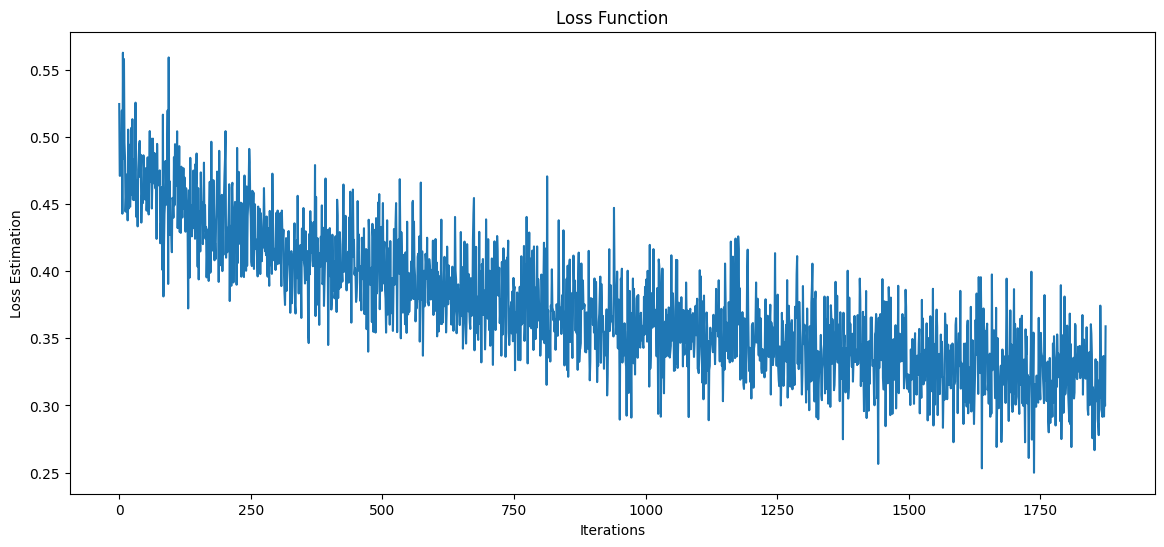

In [9]:
loss_ = train_sgd(x_train, y_train, batch_size=32, learning_rate=0.01)

plt.figure(figsize=(14,6))
plt.plot(np.arange(len(loss_)),loss_)
plt.title('Loss Function')
plt.xlabel('Iterations')
plt.ylabel('Loss Estimation')
plt.show()

## Question 6.1

Implement stochastic gradient descent for the resolution of the empirical risk minimization problem and run it for 10 epochs.

In [10]:
loss10=[]
for k in range(10):
    loss_=train_sgd(x_train,y_train, batch_size=32, learning_rate=0.01)
    loss10.append(loss_)


100%|██████████| 1875/1875 [00:38<00:00, 48.36it/s]


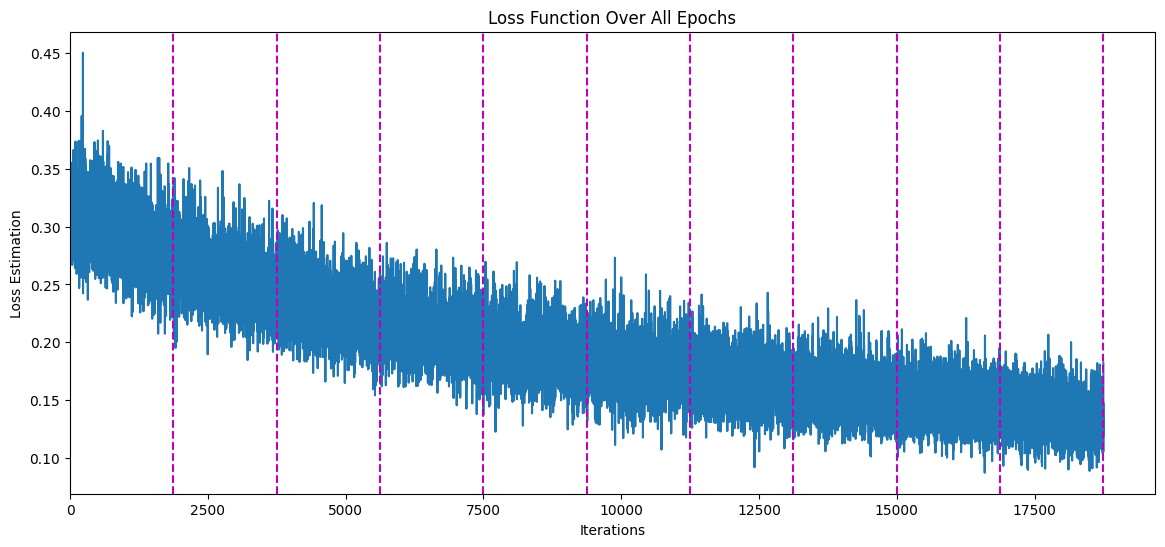

In [13]:
all_epochs_loss = []
for epoch_losses in loss10:
    all_epochs_loss.extend(epoch_losses)
each_epoch_num = len(loss_)

plt.figure(figsize=(14,6))
plt.plot(np.arange(len(all_epochs_loss)), all_epochs_loss)
plt.title('Loss Function Over All Epochs')
plt.xlabel('Iterations')
plt.ylabel('Loss Estimation')
plt.xlim(0)
for epoch in range(1, 11):
    plt.axvline(x=each_epoch_num * epoch, color='m', linestyle='--')
plt.show()

## Question 6.2

According to you, what is the advantage of such a scheme?

Use a batch to calculate the gradient and update the parameters instead of using a single sample or entire data set, it could reduce the variance, cause it use the average of the gradient in a batch and make the convergence process more stable.

## Question 6.3

Add the option of the batch size to your algorithm.

In [14]:
def sgd_update_weights(model, gradients, learning_rate):
    new_weights = [w - learning_rate * grad for w, grad in zip(model.trainable_weights, gradients)]
    model.set_weights(new_weights)

def train_sgd(x_train, y_train, epochs, batch_size, learning_rate):
    loss_values = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        batch_list = split_batch(x_train, y_train, batch_size)
        for k in tqdm(range(len(batch_list))):
            x_batch, y_batch = batch_list[k]
            with tf.GradientTape() as tape:
                logits = model(x_batch)
                loss_value = loss(y_batch, logits)
            gradients = tape.gradient(loss_value, model.trainable_weights)
            sgd_update_weights(model, gradients, learning_rate)
        ## Evaluate model
        samples_for_evaluation = np.random.randint(0, 10000, 1000)
        logits = model(x_train[samples_for_evaluation])
        loss_values.append(loss(y_train[samples_for_evaluation], logits).numpy())
    return loss_values

Epoch 1/10


100%|██████████| 1875/1875 [00:19<00:00, 97.91it/s] 


Epoch 2/10


100%|██████████| 1875/1875 [00:18<00:00, 102.01it/s]


Epoch 3/10


100%|██████████| 1875/1875 [00:18<00:00, 101.32it/s]


Epoch 4/10


100%|██████████| 1875/1875 [00:18<00:00, 100.16it/s]


Epoch 5/10


100%|██████████| 1875/1875 [00:18<00:00, 101.20it/s]


Epoch 6/10


100%|██████████| 1875/1875 [00:18<00:00, 99.83it/s] 


Epoch 7/10


100%|██████████| 1875/1875 [00:18<00:00, 101.46it/s]


Epoch 8/10


100%|██████████| 1875/1875 [00:20<00:00, 92.55it/s] 


Epoch 9/10


100%|██████████| 1875/1875 [00:18<00:00, 101.82it/s]


Epoch 10/10


100%|██████████| 1875/1875 [00:19<00:00, 95.62it/s] 


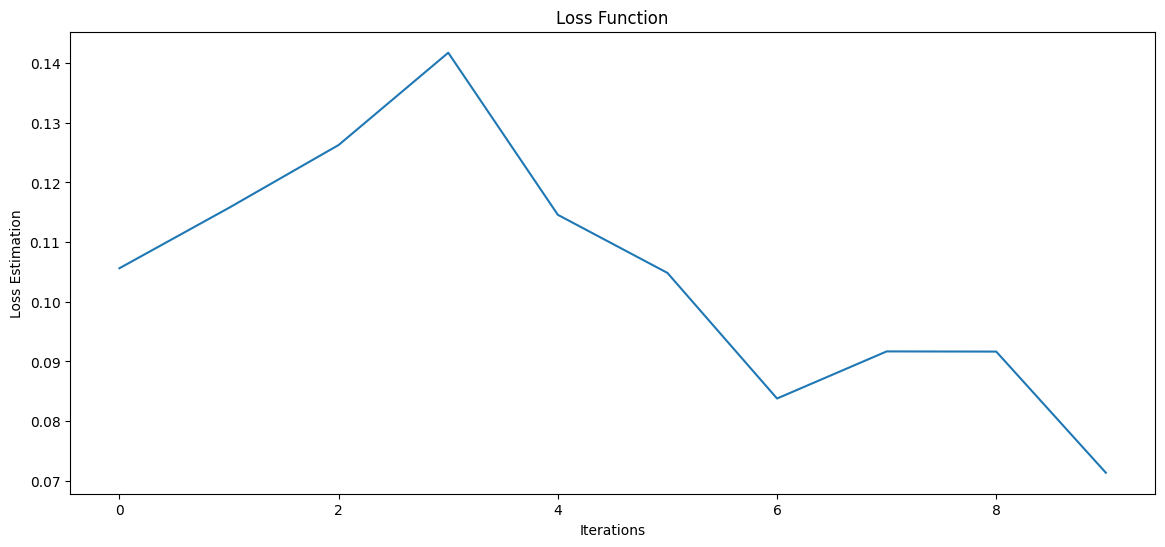

In [15]:
loss_ = []
loss_ = train_sgd(x_train, y_train, epochs=10, batch_size=32, learning_rate=0.01)

plt.figure(figsize=(14,6))
plt.plot(np.arange(len(loss_)),loss_)
plt.title('Loss Function')
plt.xlabel('Iterations')
plt.ylabel('Loss Estimation')
plt.show()

## Question 7.1

Evaluate the accuracy of the model on the training set and on the test set.

In [16]:
def evaluate_accuracy(model, x_data, y_data):
    predictions = model.predict(x_data)
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_classes == y_data)
    return accuracy

# Accuracy in training data
train_accuracy = evaluate_accuracy(model, x_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Accuracy in test data
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]
test_accuracy = evaluate_accuracy(model, x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

1875/1875 [==============================] - 3s 2ms/step
Training Accuracy: 0.9748
313/313 [==============================] - 1s 2ms/step
Test Accuracy: 0.9636
